# Oriented Grasping

So far, grasping has been limited to move our hand to be at the right position at the right time without worrying about its orientation. The goal of this lab is to explore oriented grasps. For this we assume, perception to be perfect relying on Webots built-in object detection. We will then analyze the pose of an object and derive an appropriate pose for the robot's end-effector. We will be using two world files: one with just a single can that is either laying or standing up, and one with a basket full of cans that can be in any orientation. Your goal is to implement a controller that can grasp the cans in any orientation. 

In order to better deal with rotations, we will be introducing a library by Prof. Peter Corke https://pypi.org/project/spatialmath-python/ as well as http://matthew-brett.github.io/transforms3d/reference/transforms3d.quaternions.html by Matthew Brett.


In [1]:
#!pip3 install spatialmath-python

In [2]:
import spatialmath as sm
import transforms3d as t3d

# Webots Recognition Node

Webots provides built-in object detection capability that works very similar to pixel-based segmentation tools such as YoLo, Mask R-CNN or Facebook's Detectron. Read up about it here https://www.cyberbotics.com/doc/reference/recognition

In this lab, we provide you with the ability to recognize the cans and pick out the one that you want to grasp. Specifically, the cans each have a distinct "recognition color". This emulates perfect segmentation such as can be obtained by DBScan or similar algorithms. All recognition colors are composed of 0, 0.5 and 1 (e.g., [0 0.5 0] or [1 1 0.5]).  


In [3]:
from controller import Robot, Supervisor
import numpy as np

# create the Robot instance.
robot = Supervisor() #Robot()

# get the time step of the current world.
timestep = int(robot.getBasicTimeStep())

speed=1.0

start_pos = [0,-1.382,-1.13, -2,1.63,0]#3.142]

hand_motors=[robot.getDevice("finger_1_joint_1"),
             robot.getDevice("finger_2_joint_1"),
             robot.getDevice("finger_middle_joint_1")]

ur_motors=[robot.getDevice("shoulder_pan_joint"),
           robot.getDevice("shoulder_lift_joint"),
           robot.getDevice("elbow_joint"),
           robot.getDevice("wrist_1_joint"),
           robot.getDevice("wrist_2_joint"),
           robot.getDevice("wrist_3_joint")]

for i, ur_motor in enumerate(ur_motors):
    ur_motor.setVelocity(speed)
    ur_motor.setPosition(start_pos[i])

position_sensors=[robot.getDevice("shoulder_pan_joint_sensor"),
                  robot.getDevice("shoulder_lift_joint_sensor"),
                  robot.getDevice("elbow_joint_sensor"),
                  robot.getDevice("wrist_1_joint_sensor"),
                  robot.getDevice("wrist_2_joint_sensor"),
                  robot.getDevice("wrist_3_joint_sensor")]

for position_sensor in position_sensors:
    position_sensor.enable(timestep)
    
camera = robot.getDevice("camera")
camera.enable(timestep)
camera.recognitionEnable(timestep)
camera.enableRecognitionSegmentation()

rangefinder = robot.getDevice("range-finder")
rangefinder.enable(timestep)                     

marker_node = robot.getFromDef("Marker")
marker_trans = marker_node.getField("translation")
marker_rot  = marker_node.getField("rotation")


for i in range(200):
    robot.step(timestep)
    


## Read depth and segmented image

In [4]:
robot.step(timestep)
depth_1darray = np.frombuffer(rangefinder.getRangeImage(data_type="buffer"), dtype=np.float32)
depth=np.reshape(depth_1darray,(240,320))
depth=depth*1000.0

image_1darray = camera.getRecognitionSegmentationImage()
image = np.frombuffer(image_1darray, np.uint8).reshape((camera.getHeight(), camera.getWidth(), 4))

mono = np.dot(image,[0.2989, 0.5870, 0.1140,0]).astype(int)

robot.step(timestep)

0

## Mask depth image with segmented image

The goal of segmentation is to make individual objects uniquely identifiable. In this case, the segmentation routine will label each object's pixel with a unique color. We can use this information to mask these objects in the depth image.

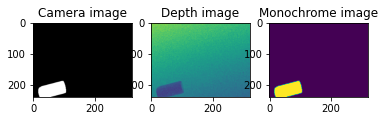

In [5]:
import matplotlib.pyplot as plt

plt.subplot(1, 3, 1)
plt.title('Camera image')
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.title('Depth image')
plt.imshow(depth)
plt.subplot(1, 3, 3)
plt.title('Monochrome image')
plt.imshow(mono)
plt.show()

# Compute Object Pose from Open3D Pointcloud

We can pick individual objects by multiplying the depth image with a mask. We can hence compute the oriented bounding box and the relative pose of the object for the robot to grasp. 

The oriented bounding box data structure provides the center (.center) and orientation (.R), which allows you to compute its pose in the robot's base frame. You can then compute an IK solution that moves the robot arm there. 

In [6]:
import open3d as o3d

cand=np.multiply(depth,mono == 254) # pick the white can

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(image), 
        o3d.geometry.Image(np.array(cand).astype('uint16')),
        convert_rgb_to_intensity=False,
        depth_scale=1000.0, depth_trunc=1.5)


can = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
       o3d.camera.PinholeCameraIntrinsic(320,240,320,240,160,120),
    project_valid_depth_only=True
)

can.paint_uniform_color([1.0, 0, 0]) # you need to color this as the segmentation color is unreliable, in particular for the white object

#o3d.visualization.draw_geometries([can])

obb = can.get_oriented_bounding_box()
obb.color = (0, 1, 0)
#o3d.visualization.draw_geometries([obb,can])


In [7]:
# building the transformation matrix from rotation, translation, and [0 0 0 1]

Randt=np.concatenate((obb.R, np.expand_dims(obb.center, axis=1)),axis=1) # pitfall: arrays need to be passed as a tuple
lastrow=np.expand_dims(np.array([0,0,0,1]),axis=0)
T=np.concatenate((Randt,lastrow))
print(T)

[[ 0.95809961 -0.25627052 -0.12794746 -0.18468278]
 [-0.27340143 -0.95140829 -0.14168246  0.2416271 ]
 [ 0.08542124 -0.17072693  0.98160864  0.5790693 ]
 [ 0.          0.          0.          1.        ]]


The rotation matrix obb.R describes the orientation of the object relative to the robot's end-effector. This is actionable information: we need to rotate and tilt the gripper so that it aligns with the object. Unfortunately, Open3D is not consistent in how it presents object orientation to us. For example, the z-axis might point up or down. We therefore cannot just assign the end-effector the same pose as the object, but need to differentiate between different cases. This gets easier when computing the pitch, yaw and roll of the object rather than dealing with a rotation matrix. 

In [8]:
RPY=sm.SO3(obb.R).rpy()

# Compute grasp pose using Forward Kinematics

So far, we computed the position of the can only in end-effector space. The robot's inverse kinematics expects coordinates in the robot's frame. Note that the robot's frame that the IK solver is using is not visible in Webots. Its origin is around 7cm above the origin of the UR5e's base in Webots. Also note that the IK solver ends at the last joint, not including the mount point and the gripper where the camera is mounted.

Obviously, we cannot directly move the end-effector to the can. We will need to come a little from above, taking into account the lengt of the gripper. By experimenting with the system, we find out that we need to rotate the can by 90 degrees in order to grasp it along the narrow dimension. 


In [9]:
import cmath
import math
from math import cos as cos
from math import sin as sin
from math import atan2 as atan2
from math import acos as acos
from math import asin as asin
from math import sqrt as sqrt
from math import pi as pi

global mat
mat=np.matrix

global d, a, alph

d = mat([0.1625, 0, 0, 0.1333, 0.0997, 0.0996]) #ur5e
a = mat([0 ,-0.425 ,-0.3922 ,0 ,0 ,0]) #ur5e
alph = mat([math.pi/2, 0, 0, math.pi/2, -math.pi/2, 0 ])  #ur5e

# ************************************************** FORWARD KINEMATICS

def AH( n,th,c  ):

  T_a = mat(np.identity(4), copy=False)
  T_a[0,3] = a[0,n-1]
  T_d = mat(np.identity(4), copy=False)
  T_d[2,3] = d[0,n-1]

  Rzt = mat([[cos(th[n-1,c]), -sin(th[n-1,c]), 0 ,0],
	         [sin(th[n-1,c]),  cos(th[n-1,c]), 0, 0],
	         [0,               0,              1, 0],
	         [0,               0,              0, 1]],copy=False)
      

  Rxa = mat([[1, 0,                 0,                  0],
			 [0, cos(alph[0,n-1]), -sin(alph[0,n-1]),   0],
			 [0, sin(alph[0,n-1]),  cos(alph[0,n-1]),   0],
			 [0, 0,                 0,                  1]],copy=False)

  A_i = T_d * Rzt * T_a * Rxa
	    

  return A_i

def HTrans(th,c ):  
  A_1=AH( 1,th,c  )
  A_2=AH( 2,th,c  )
  A_3=AH( 3,th,c  )
  A_4=AH( 4,th,c  )
  A_5=AH( 5,th,c  )
  A_6=AH( 6,th,c  )
      
  T_06=A_1*A_2*A_3*A_4*A_5*A_6
  return T_06

def get_joint_angles():
    th=[]
    for position_sensor in position_sensors:
        th.append(position_sensor.getValue())
    return th

def restorePose(angles):
    for i,ur_motor in enumerate(ur_motors):
        ur_motor.setPosition(angles[i])

    for i in range(100):
        robot.step(timestep)

We will use supervisor functionality to place an object at exactly the same position as the robot sees the object. This way, we can verify that all transforms are done correctly.

In [10]:
import transforms3d as t3d

# 1. The robot pose
angles=get_joint_angles()
theta=np.matrix([[theta] for theta in angles])
InitialPose=HTrans(theta,[0])

# 2. Compute object pose in the Webots world frame to display it
#
# T_origin_base * T_base_tip * T_tip_camera * T_camera_object
ObjectPose=np.array([[0,-1,0,-1.53],
            [1,0,0,-1.04],
            [0,0,1,0.87],
            [0,0,0,1]]) @ InitialPose @ [[1,0,0,0.0],
            [0,1,0,-0.05],
            [0,0,1,0.15],
            [0,0,0,1]] @ T                     

marker_trans.setSFVec3f([item for sublist in ObjectPose[:3,3].tolist() for item in sublist])
marker_rot.setSFRotation(t3d.quaternions.mat2quat(ObjectPose[:3,:3]).tolist())
robot.step(32)

0

Unfortunately, Open3D is not very consistent in how the object pose is provided. In addition to sensor noise, we have to deal with coordinate systems being oriented differently every time. Here, it can help to convert the rotation matrix into roll, pitch and yaw.


In [11]:
ObjectRPY=sm.SO3(obb.R).rpy()
print(ObjectRPY)

[-0.17220306 -0.08552546 -0.27797027]


You can now use similar transformations as when we placed the marker but to compute the desired orientation of the gripper, but this time to grasp. You will need to compute the desired position for the robot's

In [15]:
print(InitialPose) # The robot's tip (without gripper)
print(T) # The object's pose relative to the camera frame

DesiredPose=InitialPose # The robot will not move like that. 


[[ 1.18092061e-02 -9.79997787e-01  1.98657695e-01  3.54751659e-01]
 [-9.98247583e-01 -3.34744091e-05  5.91756921e-02 -1.27394147e-01]
 [-5.79853974e-02 -1.99008381e-01 -9.78280817e-01  7.33274907e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.95809961 -0.25627052 -0.12794746 -0.18468278]
 [-0.27340143 -0.95140829 -0.14168246  0.2416271 ]
 [ 0.08542124 -0.17072693  0.98160864  0.5790693 ]
 [ 0.          0.          0.          1.        ]]


# Implement motion

We can now use IK to compute the joint angles that we need to get to. 

In [13]:
# ************************************************** INVERSE KINEMATICS 

from numpy import linalg

global d1, a2, a3, a7, d4, d5, d6
d1 =  0.1625
a2 = -0.425
a3 = -0.3922
d4 =  0.1333
d5 =  0.0997
d6 =  0.0996

def invKine(desired_pos):# T60
  th = mat(np.zeros((6, 8)))
  P_05 = (desired_pos * mat([0,0, -d6, 1]).T-mat([0,0,0,1 ]).T)
  
  # **** theta1 ****
  
  psi = atan2(P_05[2-1,0], P_05[1-1,0])
  phi = acos(d4 /sqrt(P_05[2-1,0]*P_05[2-1,0] + P_05[1-1,0]*P_05[1-1,0]))
  #The two solutions for theta1 correspond to the shoulder
  #being either left or right
  th[0, 0:4] = pi/2 + psi + phi
  th[0, 4:8] = pi/2 + psi - phi
  th = th.real
  
  # **** theta5 ****
  
  cl = [0, 4]# wrist up or down
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH(1,th,c))
	      T_16 = T_10 * desired_pos
	      th[4, c:c+2] = + acos((T_16[2,3]-d4)/d6);
	      th[4, c+2:c+4] = - acos((T_16[2,3]-d4)/d6);

  th = th.real
  
  # **** theta6 ****
  # theta6 is not well-defined when sin(theta5) = 0 or when T16(1,3), T16(2,3) = 0.

  cl = [0, 2, 4, 6]
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH(1,th,c))
	      T_16 = linalg.inv( T_10 * desired_pos )
	      th[5, c:c+2] = atan2((-T_16[1,2]/sin(th[4, c])),(T_16[0,2]/sin(th[4, c])))
		  
  th = th.real

  # **** theta3 ****
  cl = [0, 2, 4, 6]
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH(1,th,c))
	      T_65 = AH( 6,th,c)
	      T_54 = AH( 5,th,c)
	      T_14 = ( T_10 * desired_pos) * linalg.inv(T_54 * T_65)
	      P_13 = T_14 * mat([0, -d4, 0, 1]).T - mat([0,0,0,1]).T
	      t3 = cmath.acos((linalg.norm(P_13)**2 - a2**2 - a3**2 )/(2 * a2 * a3)) # norm ?
	      th[2, c] = t3.real
	      th[2, c+1] = -t3.real

  # **** theta2 and theta 4 ****

  cl = [0, 1, 2, 3, 4, 5, 6, 7]
  for i in range(0,len(cl)):
	      c = cl[i]
	      T_10 = linalg.inv(AH( 1,th,c ))
	      T_65 = linalg.inv(AH( 6,th,c))
	      T_54 = linalg.inv(AH( 5,th,c))
	      T_14 = (T_10 * desired_pos) * T_65 * T_54
	      P_13 = T_14 * mat([0, -d4, 0, 1]).T - mat([0,0,0,1]).T
	      
	      # theta 2
	      th[1, c] = -atan2(P_13[1], -P_13[0]) + asin(a3* sin(th[2,c])/linalg.norm(P_13))
	      # theta 4
	      T_32 = linalg.inv(AH( 3,th,c))
	      T_21 = linalg.inv(AH( 2,th,c))
	      T_34 = T_32 * T_21 * T_14
	      th[3, c] = atan2(T_34[1,0], T_34[0,0])
  th = th.real

  return th

def restorePose(angles):
    for i,ur_motor in enumerate(ur_motors):
        ur_motor.setPosition(angles[i])

    for i in range(350):
        robot.step(timestep)

In [14]:
# select the solution with the lowest joint motion, weighted strongest by the shoulder lift joint
score=[]
iksolution=invKine(DesiredPose)
for i in range(max(iksolution.shape)):
    goal=iksolution[:,i]
    goal=[angle.item() for angle in goal]
    score.append(sum(np.multiply([3,5,4,3,2,1],np.sqrt(np.square(np.array(angles)-np.array(goal))))))
    print("Solution: {} Score {}".format(i,score[i]))
    #restorePose(goal)
          
    

Solution: 0 Score 30.3490825343657
Solution: 1 Score 33.527455307223896
Solution: 2 Score 27.36429184617987
Solution: 3 Score 32.2517101917241
Solution: 4 Score 30.466535222524804
Solution: 5 Score 11.824070788612849
Solution: 6 Score 38.497801301682806
Solution: 7 Score 27.005503487784203


In [15]:
best_goal = iksolution[:,score.index(min(score))]
best_goal=[angle.item() for angle in best_goal]

In [16]:
restorePose(best_goal)